In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
import random

import scipy.cluster.hierarchy as sch
from scipy import stats

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [30]:
data = np.zeros((100000, 100, 1))
for i in range(data.shape[0]):
    for j in range(data.shape[2]):
        data[i, :, j] = np.random.normal((i%20 * 5), np.random.randint(1, 25), data.shape[1])

In [31]:
timesteps = 100  # Length of your sequences
input_dim = 1 
latent_dim = 16

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64)(inputs)
encoded = Dense(latent_dim)(encoded)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(1))(decoded)

autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=1)
# autoencoder.fit(data[2000:],data[2000:], epochs=1000, validation_data=(data[:2000],data[:2000]), callbacks=[es], batch_size=1024)

In [32]:
autoencoder = tf.keras.models.load_model("autoencoder.h5")
encoder = tf.keras.models.load_model("encoder.h5")

Text(0, 0.5, 'mse')

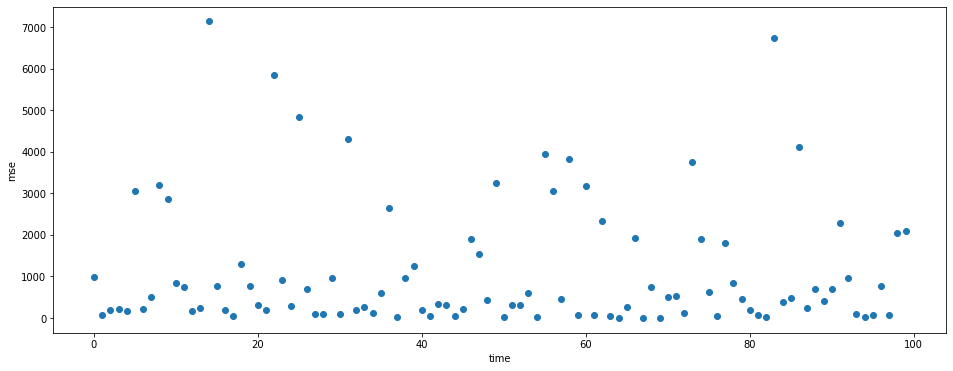

In [33]:
predictions = autoencoder.predict(np.expand_dims(data[11], axis=0))
mse = np.power(data[11] - predictions[0][0], 2)

plt.figure(figsize=(16,6))
plt.scatter(range(data.shape[1]), mse)
plt.xlabel('time'); plt.ylabel('mse')

In [34]:
x = np.zeros((4, 1000))
y = x[:, 1:101]
y.shape
z = encoder.predict(y)
z.shape
from scipy.spatial import distance_matrix
distance_matrix(z, z)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [35]:
import pandas as pd
pd.__version__

'1.1.5'

In [36]:
from tqdm import tqdm
def compute_distances(sensors, encoder, window=5, plot=True):
    sensor_array = np.vstack(sensors)
    num_sensors = len(sensors)
    total_timesteps = len(sensors[0])
    truncated_timestep = timesteps
    sensor_distance_timeseries = np.zeros((total_timesteps - truncated_timestep, num_sensors, num_sensors))
    time_vec = np.arange(total_timesteps - truncated_timestep)
    for i in tqdm(range(total_timesteps - truncated_timestep)):
        truncated_timeseries = sensor_array[:, i:i+truncated_timestep]
        truncated_encodings = encoder.predict(truncated_timeseries)
        sensor_distance_timeseries[i] = distance_matrix(truncated_encodings, truncated_encodings)
    if plot:
        fig, axs = plt.subplots(num_sensors, num_sensors, sharex=True, sharey=True, figsize=(16, 16))
        for i in range(num_sensors):
            for j in range(num_sensors):
                axs[i,j].plot(time_vec, pd.Series(sensor_distance_timeseries[:, i, j]).rolling(window).mean())
                axs[i,j].set_title("")
                axs[i,j].set(xlabel=f'sensor {j}', ylabel=f'sensor {i}')
        for ax in axs.flat:
            ax.label_outer()
    return sensor_distance_timeseries

# Profiling

In [37]:
from sklearn.decomposition import FastICA, TruncatedSVD, PCA, FactorAnalysis
import umap

class Pca:
    def __init__(self, data):
        self.model = PCA(16).fit(data)
    def predict(self, data):
        return self.model.transform(data)

class FactorAnal:
    def __init__(self, data):
        self.model = FactorAnalysis(32).fit(data)
    def predict(self, data):
        return self.model.transform(data)

class ICA:
    def __init__(self, data):
        self.model = FastICA(n_components=16, random_state=12).fit(data)
    def predict(self, data):
        return self.model.transform(data)
    
pca = Pca(data.reshape((100000, 100)))


In [38]:
encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
Total params: 17,936
Trainable params: 17,936
Non-trainable params: 0
_________________________________________________________________


In [39]:
# layers * timesteps * 8 * 2 * hiddenSize * minibatch * (hiddenSize + 1)
# = 2*100*8*2*64*65
# approx 13 million flops

In [40]:
# pca is matrix multiplication of a 1x100 vector and 100x16 vector, so approx 1600 flops

In [24]:
%%timeit
with tf.device("/cpu:0"):
    encoder.predict(np.zeros((1,100)))

50.3 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%%timeit
pca.predict(np.zeros((1,100)))

74.9 µs ± 2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Select Encoder

In [41]:
from sklearn.decomposition import FastICA, TruncatedSVD, PCA, FactorAnalysis
import umap

class Pca:
    def __init__(self, data):
        self.model = PCA(16).fit(data)
    def predict(self, data):
        return self.model.transform(data)

class FactorAnal:
    def __init__(self, data):
        self.model = FactorAnalysis(32).fit(data)
    def predict(self, data):
        return self.model.transform(data)

class ICA:
    def __init__(self, data):
        self.model = FastICA(n_components=16, random_state=12).fit(data)
    def predict(self, data):
        return self.model.transform(data)
    
pca = Pca(data.reshape((100000, 100)))
# encoder = FactorAnal(data.reshape((100000, 100)))
# encoder = ICA(data.reshape((100000, 100)))

In [42]:
center_temp = 50
center_std = 2
total_time = 150
deltas = np.arange(0,100,2)
autoencoder_dists = np.zeros((50))
pca_dists = np.zeros((50))
for idx, delta_t in enumerate(tqdm(range(0, 100, 2))):
    sensor_1 = np.random.normal(center_temp + delta_t, center_std, total_time)
    sensor_2 = np.random.normal(center_temp, center_std, total_time)
    sensor_array = np.vstack([sensor_1, sensor_2])
    sensor_autoencoder = np.zeros((50))
    sensor_pca = np.zeros((50))
    for i in range(50):
        truncated_timeseries = sensor_array[:, i:i+100]
        truncated_autoencodings = encoder.predict(truncated_timeseries)
        truncated_pca = pca.predict(truncated_timeseries)
        sensor_autoencoder[i] = distance_matrix(truncated_autoencodings, truncated_autoencodings)[0][1]
        sensor_pca[i] = distance_matrix(truncated_pca, truncated_pca)[0][1]
    autoencoder_dists[idx] = np.mean(sensor_autoencoder)
    pca_dists[idx] = np.mean(sensor_pca)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:50<00:00,  2.20s/it]


In [43]:
deltas

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98])

In [44]:
autoencoder_dists

array([ 0.23226241,  0.4720696 ,  0.90759435,  1.28998234,  1.81762452,
        2.2984505 ,  2.63470838,  3.16870278,  3.68440298,  4.21441826,
        4.73280016,  5.39254948,  6.11851736,  6.80325983,  7.4411504 ,
        8.07481104,  8.61772647, 10.44817179, 12.47123301, 15.75572365,
       17.53045806, 20.5348661 , 21.47422587, 21.71835885, 21.74737298,
       21.79386092, 21.65998715, 21.69079167, 21.70106808, 21.55514767,
       21.55217609, 21.53691322, 21.32650677, 20.84576812, 20.33138739,
       20.1282548 , 19.97290762, 19.97191679, 19.95103915, 19.8739518 ,
       19.81675385, 19.78695659, 19.7760183 , 19.78026541, 19.73864932,
       19.67975034, 19.60820935, 19.5628757 , 19.51324663, 19.54347196])

In [45]:
pca_dists

array([ 10.07476338,  23.08466064,  39.1073746 ,  62.94652147,
        80.34625086, 105.57278336, 119.87926762, 138.6225276 ,
       162.52549517, 182.67446397, 198.80910413, 216.62617737,
       240.81799967, 257.87933586, 278.9515943 , 304.66123664,
       317.9036968 , 339.55118121, 360.57692431, 383.65368905,
       402.91935627, 421.65134291, 442.82251582, 457.10641094,
       478.74074127, 497.14421064, 523.65550003, 540.44313779,
       561.40088501, 576.17736879, 597.4944817 , 621.32434447,
       641.77096217, 655.90474086, 679.38020812, 702.0927946 ,
       723.27880269, 738.23063016, 758.87498855, 778.36955268,
       800.13297739, 820.52118837, 841.97888071, 859.52107996,
       880.43290596, 899.88942832, 920.22509944, 940.40969131,
       956.97987292, 983.11501023])

In [1]:
plt.plot(deltas, autoencoder_dists, color="blue")
plt.plot(deltas, pca_dists, color="orange")
plt.yscale("log")
plt.ylabel("Distance Difference")
plt.xlabel("Difference in Means")

NameError: name 'plt' is not defined

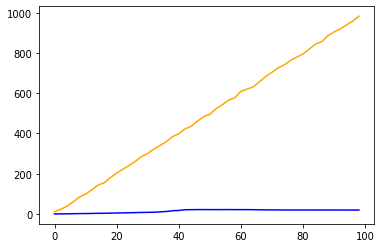

In [28]:
plt.plot(deltas, autoencoder_dists, color="blue")
plt.plot(deltas, pca_dists, color="orange")
# plt.yscale("log")

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1900/1900 [00:00<00:00, 7242.88it/s]


8.321108049724696 5.070774796271504


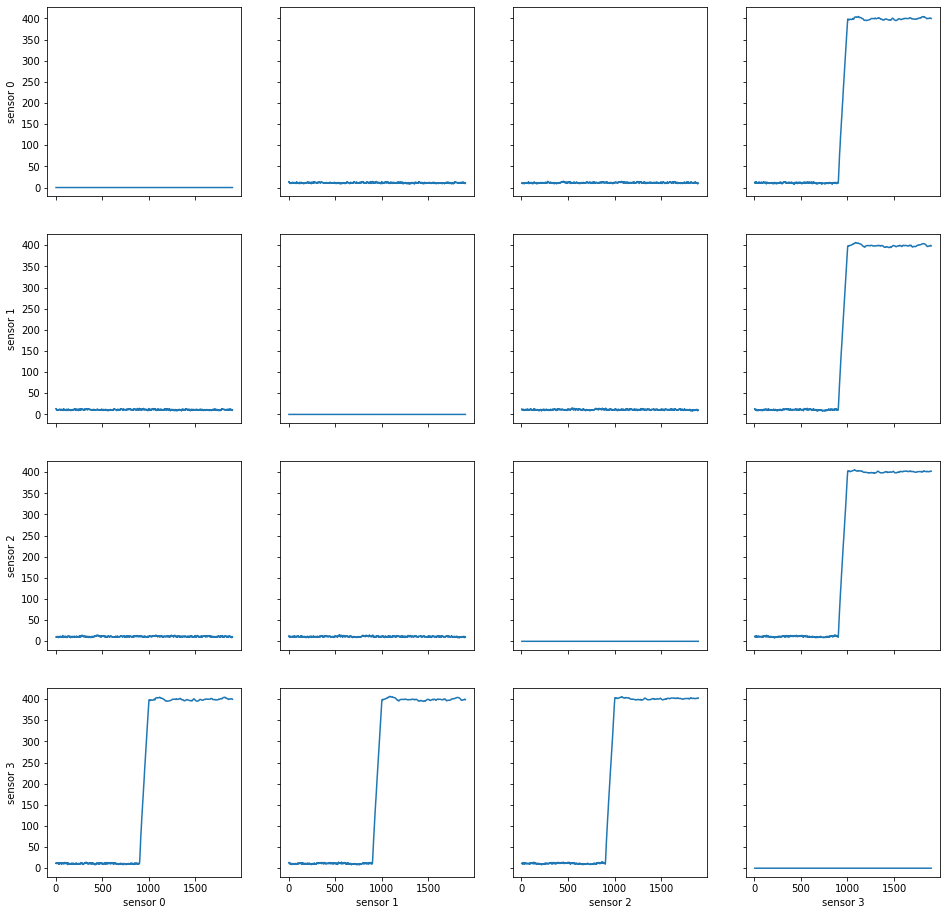

In [56]:
# Test 4

center_temp = 60
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(20, center_std, total_time//2)])
dist_series = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], pca)
print(np.mean(dist_series[:800]), np.std(dist_serie[:800]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1900/1900 [00:00<00:00, 7188.36it/s]


75.07862839405885 46.18025713550887


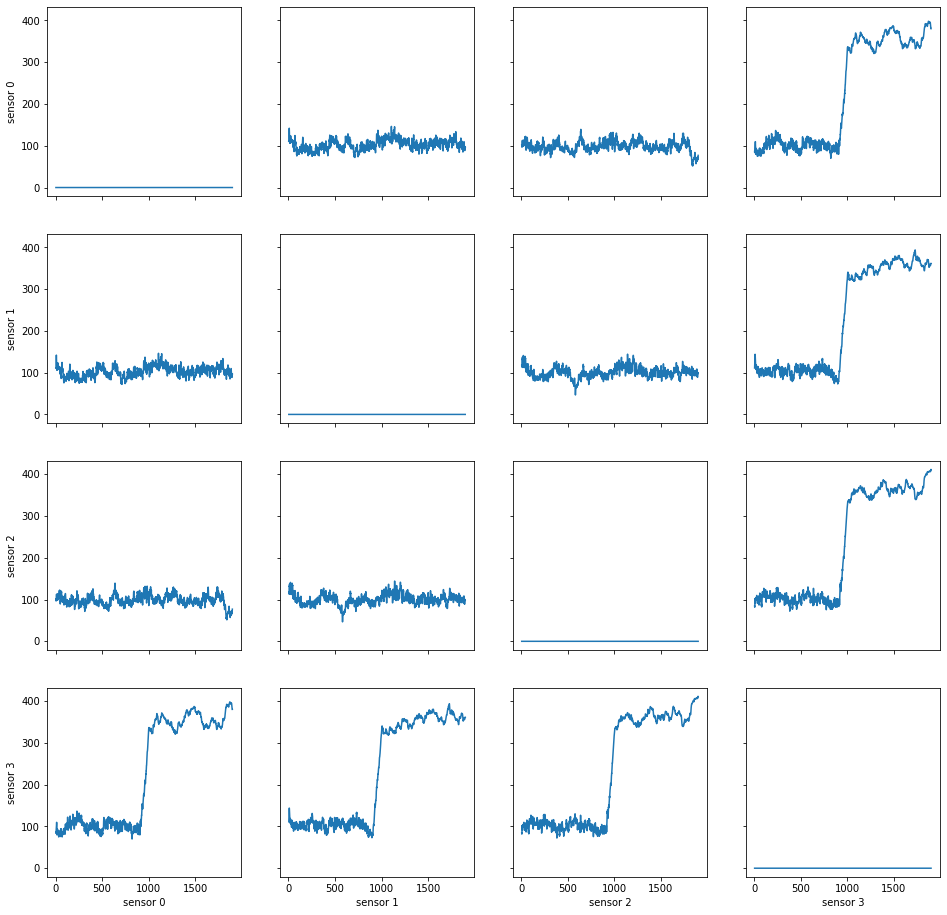

In [57]:
# Erasure Noise

center_temp = 60
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(20, center_std, total_time//2)])
mask_1 = np.random.choice([0, 1], 2000, p=[0.1, 0.9])
mask_2 = np.random.choice([0, 1], 2000, p=[0.1, 0.9])
mask_3 = np.random.choice([0, 1], 2000, p=[0.1, 0.9])
mask_4 = np.random.choice([0, 1], 2000, p=[0.1, 0.9])
sensor_1 = np.multiply(sensor_1, mask_1)
sensor_2 = np.multiply(sensor_2, mask_2)
sensor_3 = np.multiply(sensor_3, mask_3)
sensor_4 = np.multiply(sensor_4, mask_4)

dist_series = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], pca)
print(np.mean(dist_series[:800]), np.std(dist_series[:800]))

# Auto Encoder

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1900/1900 [01:21<00:00, 23.24it/s]


0.3151761088423232 0.7455730521559364


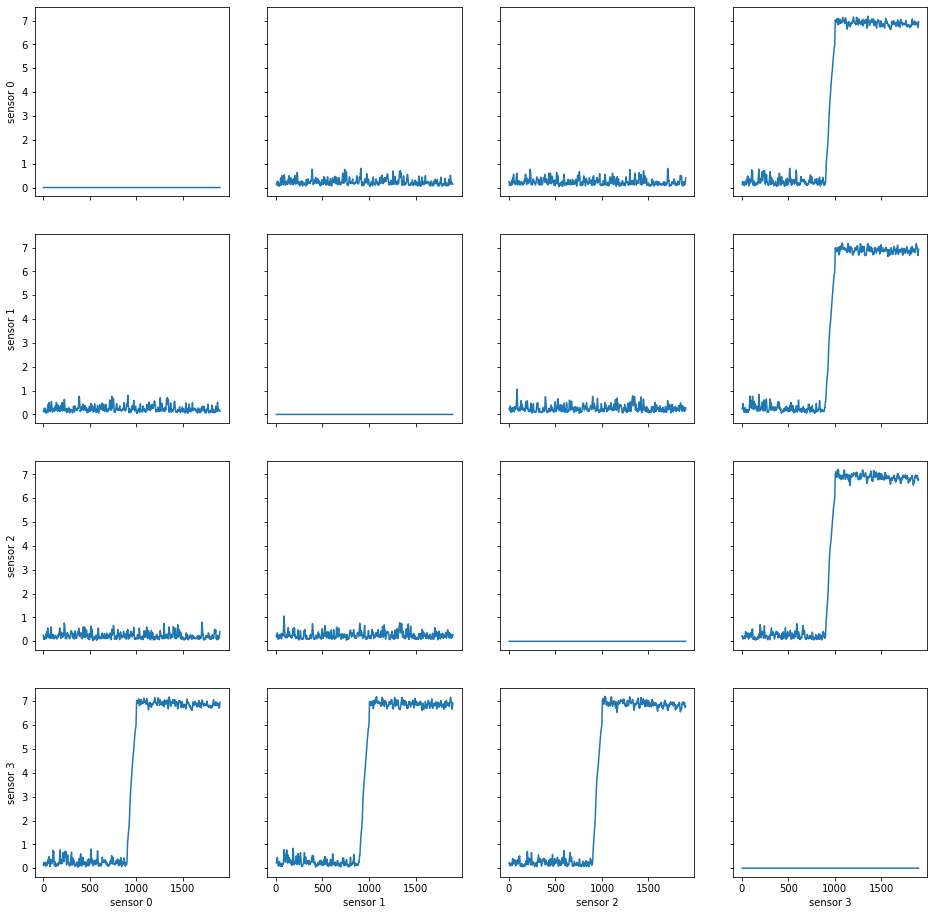

In [54]:
# Test 4

center_temp = 60
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(20, center_std, total_time//2)])
dist_series = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], encoder)
print(np.mean(dist_series[:999]), np.std(dist_series[:999]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1900/1900 [01:22<00:00, 23.10it/s]


1.5396042350804198 1.373193513896209


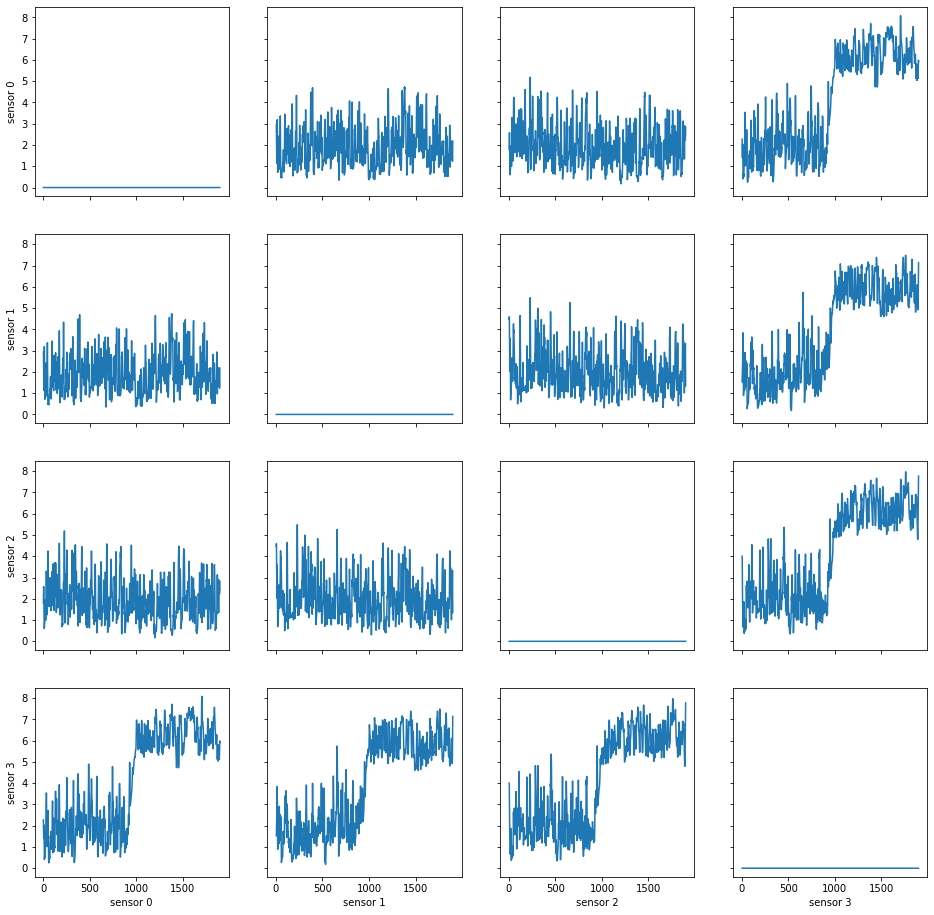

In [55]:
# Erasure Noise

center_temp = 60
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(20, center_std, total_time//2)])
mask_1 = np.random.choice([0, 1], 2000, p=[0.1, 0.9])
mask_2 = np.random.choice([0, 1], 2000, p=[0.1, 0.9])
mask_3 = np.random.choice([0, 1], 2000, p=[0.1, 0.9])
mask_4 = np.random.choice([0, 1], 2000, p=[0.1, 0.9])
sensor_1 = np.multiply(sensor_1, mask_1)
sensor_2 = np.multiply(sensor_2, mask_2)
sensor_3 = np.multiply(sensor_3, mask_3)
sensor_4 = np.multiply(sensor_4, mask_4)

dist_series = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], encoder)
print(np.mean(dist_series[:999]), np.std(dist_series[:999]))

In [19]:
def two_sample_t_test(dist_series, alpha=1e-20, prior_series_length=100, new_series_length=10):
    for i in range(dist_series.shape[0] - prior_series_length - new_series_length):
        for j in range(dist_series.shape[1]):
            num_anomalous_dists = 0
            for k in range(dist_series.shape[2]):
                statistic, pval = stats.ttest_ind(
                    dist_series[i:i+prior_series_length, j, k], 
                    dist_series[i+prior_series_length:i+prior_series_length+new_series_length, j, k],
                    equal_var = False,
                )
                if j!=k and pval < alpha:
                    num_anomalous_dists += 1
            if num_anomalous_dists > 1:
                return j, i

In [20]:
center_temp = 60
center_std = 2
total_time = 1000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp+20, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp+20, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp+20, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp+20, 10, total_time//2)])
dist_series = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], encoder, plot=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:37<00:00, 24.19it/s]


In [21]:
two_sample_t_test(dist_series)

d:\projects\sensor\env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(2, 455)

In [22]:
center_temp = 60
center_std = 2
total_time = 1000
sensor_1 = np.concatenate([np.random.normal(10, center_std, total_time//2), np.random.normal(20, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(20, center_std, total_time//2), np.random.normal(30, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(30, center_std, total_time//2), np.random.normal(40, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(40, center_std, total_time//2), np.random.normal(40, center_std, total_time//2)])
dist_series = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], encoder, plot=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:36<00:00, 24.42it/s]


In [23]:
two_sample_t_test(dist_series)

(3, 329)